In [ ]:
from google.colab import files
upload = files.upload()

Saving utkface_train.zip to utkface_train.zip


In [ ]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = "utkface_train.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("utkface_dataset")

In [ ]:
from google.colab import files
upload = files.upload()

Saving specific_dataset.zip to specific_dataset.zip


In [ ]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = "specific_dataset.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("test_dataset")

In [ ]:
## in 'cnn models+utkface+ourdataset+CHG' i determined the cropted images and there wasn't any.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image

In [ ]:
## splitting to the train and validation

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# The dataset directory
input_folder = '/content/utkface_dataset/utkface_train'
# splitted dataset directory
output = 'splitted_dataset'

# Split with a ratio of 80-20 train and validation
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2))

Copying files: 13207 files [00:02, 5098.89 files/s]


In [ ]:
## previously in VGG16 the number of images in each category was counted

# **ResNet 18**

In [ ]:
## ResNet 18

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam

In [ ]:
# This implementation defines ResNet18 architecture with residual blocks.
# You can then use this base_model in your code similar to how you were using VGG16.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, strides=(1, 1), downsample=False):
    identity = x

    # First convolutional layer of the block
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer of the block
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # If downsample is True, perform downsampling
    if downsample:
        identity = Conv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)

    # Add the identity (skip connection) to the output
    x = tf.keras.layers.add([x, identity])
    x = Activation('relu')(x)
    return x

def ResNet18(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Stack of residual blocks
    x = residual_block(x, filters=64, downsample=False)
    x = residual_block(x, filters=64, downsample=False)
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128, downsample=False)
    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256, downsample=False)
    x = residual_block(x, filters=512, downsample=True)
    x = residual_block(x, filters=512, downsample=False)

    # Global average pooling and dense layer for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model

img_height, img_width = 128, 128

# Create ResNet18 model
base_model = ResNet18(input_shape=(img_height, img_width, 3), num_classes=4)

In [ ]:
# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/test_dataset/specific_dataset'


num_classes = 4

# Define image dimensions
img_height, img_width = 128, 128
batch_size = 32

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:

# Load the pre-trained ResNet18 model
# base_model = ResNet18(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for ethnicities

# Compile the model

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             # loss='categorical_crossentropy',
             # metrics=['accuracy'])


In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/10
330/330 [==============================] - 44s 108ms/step - loss: 1.3134 - accuracy: 0.4510 - val_loss: 1.2835 - val_accuracy: 0.4577
Epoch 2/10
330/330 [==============================] - 35s 107ms/step - loss: 1.2839 - accuracy: 0.4564 - val_loss: 1.2827 - val_accuracy: 0.4558
Epoch 3/10
330/330 [==============================] - 35s 105ms/step - loss: 1.2837 - accuracy: 0.4568 - val_loss: 1.2820 - val_accuracy: 0.4566
Epoch 4/10
330/330 [==============================] - 38s 115ms/step - loss: 1.2827 - accuracy: 0.4565 - val_loss: 1.2822 - val_accuracy: 0.4562
Epoch 5/10
330/330 [==============================] - 35s 106ms/step - loss: 1.2828 - accuracy: 0.4568 - val_loss: 1.2804 - val_accuracy: 0.4577
Epoch 6/10
330/330 [==============================] - 38s 116ms/step - loss: 1.2838 - accuracy: 0.4568 - val_loss: 1.2812 - val_accuracy: 0.4573
Epoch 7/10
330/330 [==============================] - 35s 105ms/step - loss: 1.2821 - accuracy: 0.4572 - val_loss: 1.2827 - val_ac

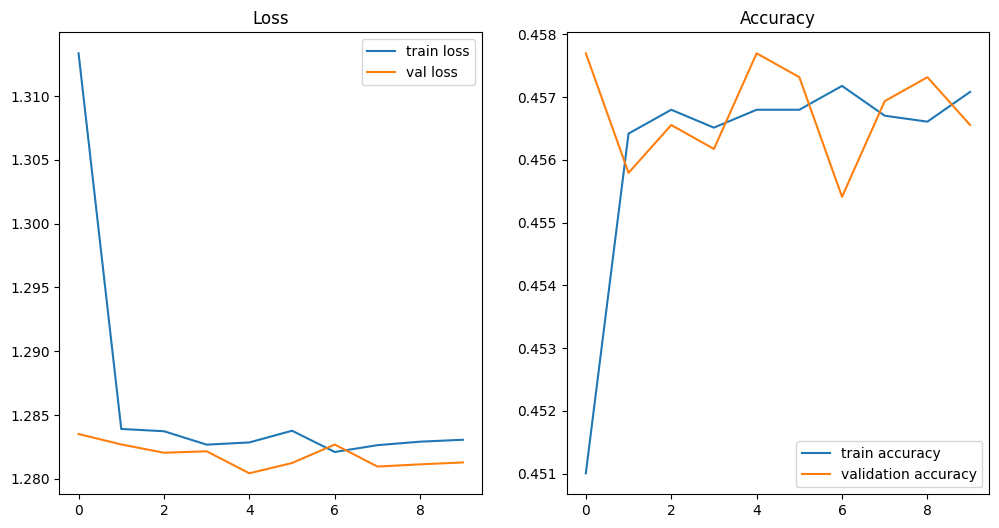

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## the model resnet 18 is not good at all as you can see in the picture

In [ ]:
## ResNet 50

# **ResNet 50**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/test_dataset/specific_dataset'


num_classes = 4

# Define image dimensions
img_height, img_width = 128, 128
batch_size = 32

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/10
330/330 [==============================] - 25s 62ms/step - loss: 1.3059 - accuracy: 0.4440 - val_loss: 1.2603 - val_accuracy: 0.4577
Epoch 2/10
330/330 [==============================] - 19s 56ms/step - loss: 1.2733 - accuracy: 0.4587 - val_loss: 1.2511 - val_accuracy: 0.4585
Epoch 3/10
330/330 [==============================] - 18s 56ms/step - loss: 1.2520 - accuracy: 0.4630 - val_loss: 1.2344 - val_accuracy: 0.4581
Epoch 4/10
330/330 [==============================] - 21s 63ms/step - loss: 1.2357 - accuracy: 0.4678 - val_loss: 1.2249 - val_accuracy: 0.4779
Epoch 5/10
330/330 [==============================] - 19s 56ms/step - loss: 1.2214 - accuracy: 0.4731 - val_loss: 1.2001 - val_accuracy: 0.4695
Epoch 6/10
330/330 [==============================] - 20s 61ms/step - loss: 1.2003 - accuracy: 0.4871 - val_loss: 1.1764 - val_accuracy: 0.4985
Epoch 7/10
330/330 [==============================] - 18s 56ms/step - loss: 1.1771 - accuracy: 0.4987 - val_loss: 1.1828 - val_accuracy:

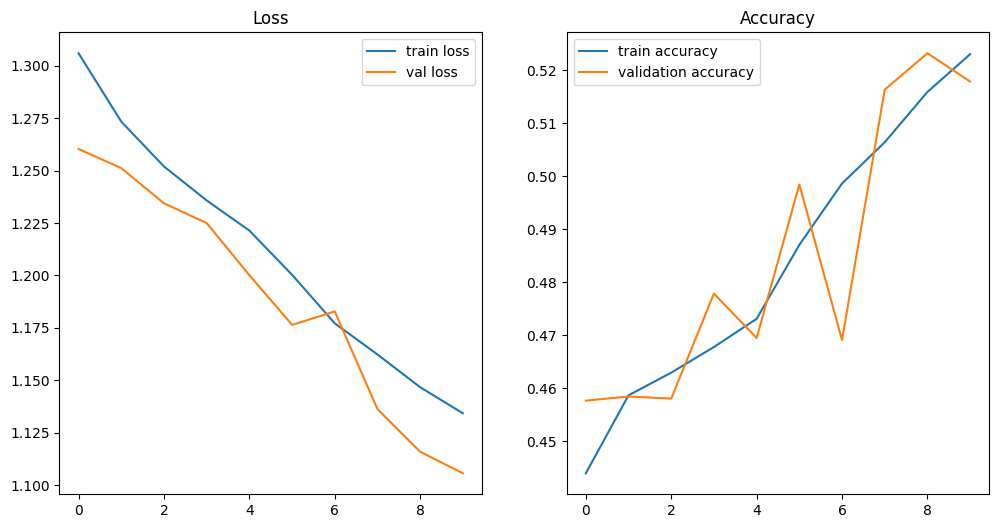

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## changing the batch size to 64 and epoch to 30
## choon batch size ro taghir dadam learning rate ro ham kam mikonam
## (If you increase the batch size, you might want to decrease the learning rate.If you decrease the batch size, you might want to increase the learning rate.)

# **batch=64, epoch=30, opt=Adam-0.00005**

In [ ]:
# Define image dimensions
img_height, img_width = 128, 128
batch_size = 64

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/30
165/165 [==============================] - 22s 103ms/step - loss: 1.3321 - accuracy: 0.4292 - val_loss: 1.2616 - val_accuracy: 0.4569
Epoch 2/30
165/165 [==============================] - 16s 98ms/step - loss: 1.2637 - accuracy: 0.4592 - val_loss: 1.2447 - val_accuracy: 0.4558
Epoch 3/30
165/165 [==============================] - 17s 100ms/step - loss: 1.2448 - accuracy: 0.4648 - val_loss: 1.2264 - val_accuracy: 0.4588
Epoch 4/30
165/165 [==============================] - 16s 96ms/step - loss: 1.2302 - accuracy: 0.4695 - val_loss: 1.2065 - val_accuracy: 0.4619
Epoch 5/30
165/165 [==============================] - 16s 97ms/step - loss: 1.2100 - accuracy: 0.4824 - val_loss: 1.1952 - val_accuracy: 0.4619
Epoch 6/30
165/165 [==============================] - 16s 96ms/step - loss: 1.1928 - accuracy: 0.4878 - val_loss: 1.1742 - val_accuracy: 0.4947
Epoch 7/30
165/165 [==============================] - 16s 97ms/step - loss: 1.1796 - accuracy: 0.4966 - val_loss: 1.1658 - val_accurac

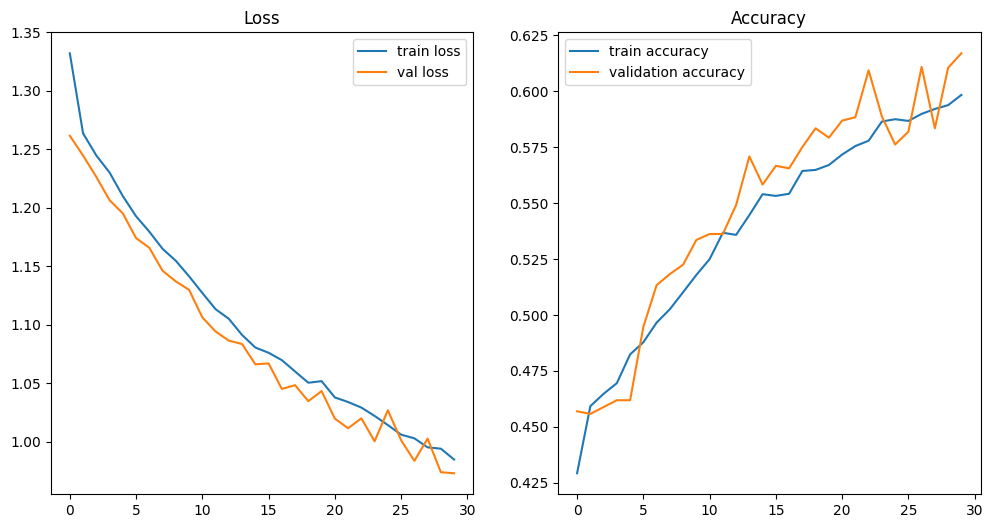

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## changing the batch size to 128
## and epoch to 50

# **batch=128 - epoch=50**

In [ ]:
# Define image dimensions
img_height, img_width = 128, 128
batch_size = 128

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/50
82/82 [==============================] - 20s 204ms/step - loss: 0.9720 - accuracy: 0.6076 - val_loss: 0.9667 - val_accuracy: 0.6172
Epoch 2/50
82/82 [==============================] - 15s 184ms/step - loss: 0.9676 - accuracy: 0.6048 - val_loss: 0.9667 - val_accuracy: 0.6121
Epoch 3/50
82/82 [==============================] - 15s 177ms/step - loss: 0.9663 - accuracy: 0.6045 - val_loss: 0.9601 - val_accuracy: 0.6047
Epoch 4/50
82/82 [==============================] - 15s 182ms/step - loss: 0.9667 - accuracy: 0.6068 - val_loss: 0.9553 - val_accuracy: 0.6098
Epoch 5/50
82/82 [==============================] - 15s 177ms/step - loss: 0.9598 - accuracy: 0.6121 - val_loss: 0.9591 - val_accuracy: 0.6020
Epoch 6/50
82/82 [==============================] - 15s 188ms/step - loss: 0.9634 - accuracy: 0.6069 - val_loss: 0.9541 - val_accuracy: 0.6258
Epoch 7/50
82/82 [==============================] - 14s 176ms/step - loss: 0.9591 - accuracy: 0.6108 - val_loss: 0.9532 - val_accuracy: 0.6137

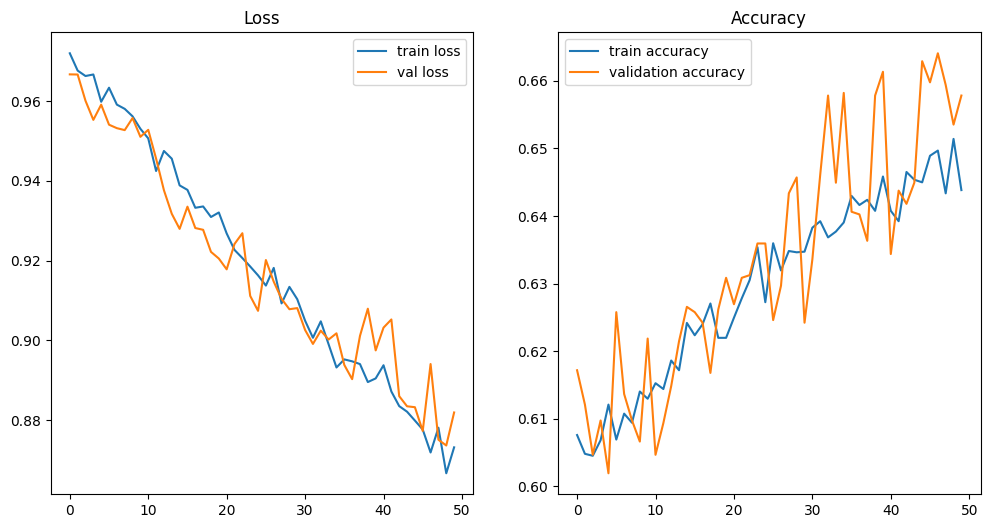

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
# data augmentation with epoch 30 and batch size 64

# **Data augmentation - epoch=30 - batch=64**

In [ ]:
# Define image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 64

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for ethnicities

# Define your optimizer with the adjusted learning rate
optimizer = Adam(learning_rate=0.00005)  # Adjusted learning rate

# Compile your model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.
Epoch 1/30
165/165 [==============================] - 64s 366ms/step - loss: 1.3449 - accuracy: 0.4294 - val_loss: 1.2782 - val_accuracy: 0.4562
Epoch 2/30
165/165 [==============================] - 58s 353ms/step - loss: 1.2895 - accuracy: 0.4568 - val_loss: 1.2719 - val_accuracy: 0.4573
Epoch 3/30
165/165 [==============================] - 58s 351ms/step - loss: 1.2878 - accuracy: 0.4562 - val_loss: 1.2710 - val_accuracy: 0.4569
Epoch 4/30
165/165 [==============================] - 58s 354ms/step - loss: 1.2837 - accuracy: 0.4571 - val_loss: 1.2695 - val_accuracy: 0.4588
Epoch 5/30
165/165 [==============================] - 58s 352ms/step - loss: 1.2814 - accuracy: 0.4564 - val_loss: 1.2664 - val_accuracy: 0.4592
Epoch 6/30
165/165 [==============================] - 60s 365ms/step - loss: 1.2801 - accuracy: 0.4561 - val_loss: 1.2660 - val_accuracy: 0.4577
Epoch 7/30
165/165 [=========================

In [ ]:
# so data augmentation doesnt have a good result, but the overfiiting problem doesn't exist at all

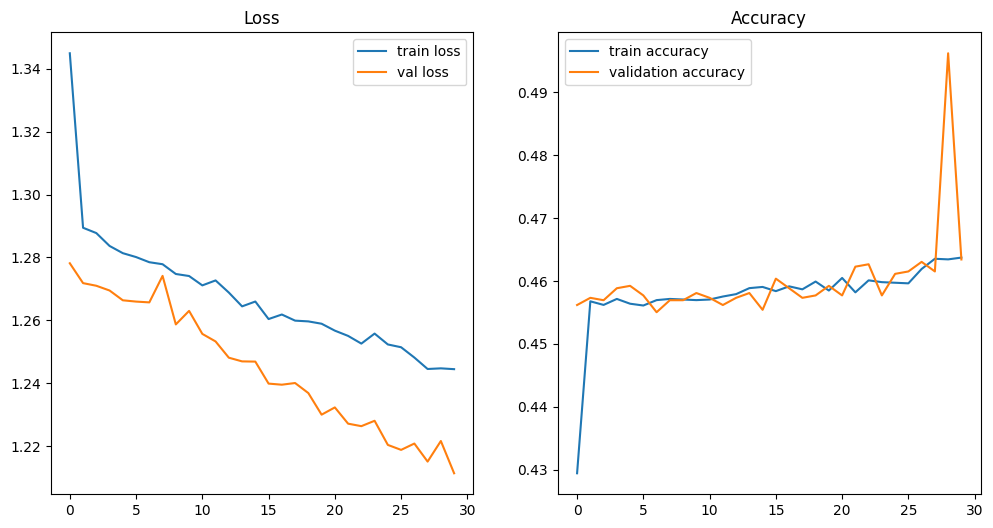

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## try another cnn model

In [ ]:
###### using DenseNet169 ########

# **DenseNet 169**

In [ ]:
# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/test_dataset/specific_dataset'


num_classes = 4

# Define image dimensions
img_height, img_width = 128, 128
batch_size = 64

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet169

In [ ]:
# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# Compile the model

#model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             # loss='categorical_crossentropy',
             # metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

51877672/51877672 [==============================] - 2s 0us/step


In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
165/165 [==============================] - 39s 151ms/step - loss: 1.0522 - accuracy: 0.6122 - val_loss: 0.7664 - val_accuracy: 0.7104
Epoch 2/20
165/165 [==============================] - 19s 116ms/step - loss: 0.7366 - accuracy: 0.7157 - val_loss: 0.7041 - val_accuracy: 0.7279
Epoch 3/20
165/165 [==============================] - 18s 106ms/step - loss: 0.6442 - accuracy: 0.7617 - val_loss: 0.6386 - val_accuracy: 0.7572
Epoch 4/20
165/165 [==============================] - 19s 116ms/step - loss: 0.5832 - accuracy: 0.7803 - val_loss: 0.6444 - val_accuracy: 0.7572
Epoch 5/20
165/165 [==============================] - 19s 116ms/step - loss: 0.5293 - accuracy: 0.8044 - val_loss: 0.6220 - val_accuracy: 0.7683
Epoch 6/20
165/165 [==============================] - 17s 104ms/step - loss: 0.5018 - accuracy: 0.8117 - val_loss: 0.6247 - val_accuracy: 0.7732
Epoch 7/20
165/165 [==============================] - 19s 117ms/step - loss: 0.4601 - accuracy: 0.8294 - val_loss: 0.6059 - val_ac

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
# changing the batch to 128 and LR to 0.00005

# **batch=128 - Lr=0.00005**

In [ ]:
num_classes = 4

# Define image dimensions
img_height, img_width = 128, 128
batch_size = 128

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:
# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for ethnicities

# Compile the model

#model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             # loss='categorical_crossentropy',
             # metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
82/82 [==============================] - 41s 307ms/step - loss: 1.0469 - accuracy: 0.5979 - val_loss: 0.7711 - val_accuracy: 0.7055
Epoch 2/20
82/82 [==============================] - 16s 188ms/step - loss: 0.7492 - accuracy: 0.7136 - val_loss: 0.6912 - val_accuracy: 0.7328
Epoch 3/20
82/82 [==============================] - 16s 191ms/step - loss: 0.6609 - accuracy: 0.7462 - val_loss: 0.6678 - val_accuracy: 0.7410
Epoch 4/20
82/82 [==============================] - 18s 216ms/step - loss: 0.5802 - accuracy: 0.7810 - val_loss: 0.6396 - val_accuracy: 0.7625
Epoch 5/20
82/82 [==============================] - 16s 189ms/step - loss: 0.5279 - accuracy: 0.8025 - val_loss: 0.6187 - val_accuracy: 0.7637
Epoch 6/20
82/82 [==============================] - 18s 213ms/step - loss: 0.4689 - accuracy: 0.8289 - val_loss: 0.6124 - val_accuracy: 0.7773
Epoch 7/20
82/82 [==============================] - 16s 192ms/step - loss: 0.4361 - accuracy: 0.8412 - val_loss: 0.6036 - val_accuracy: 0.7801

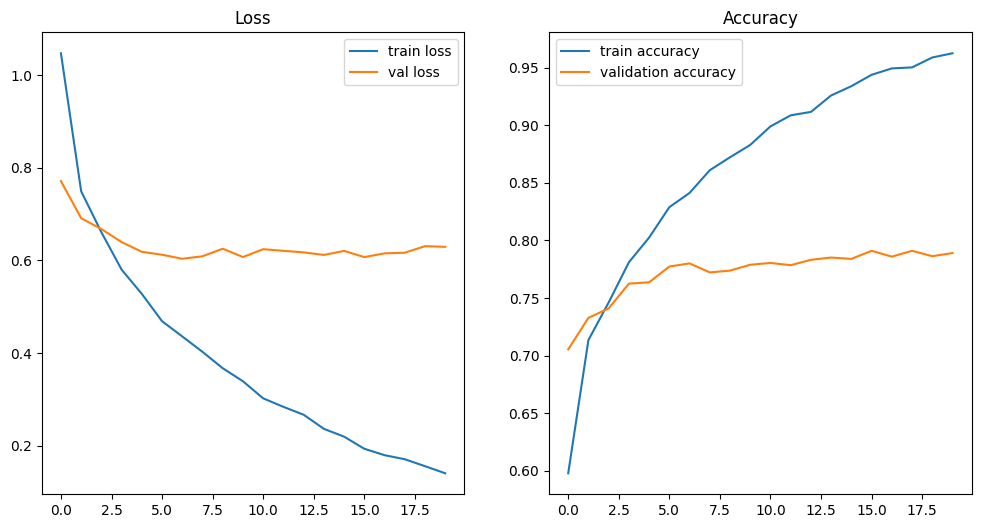

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## changing the optimiser to SGD

# **opt=SGD - Lr=0.0001**

In [ ]:
from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
82/82 [==============================] - 29s 229ms/step - loss: 0.1167 - accuracy: 0.9744 - val_loss: 0.6344 - val_accuracy: 0.7934
Epoch 2/20
82/82 [==============================] - 16s 193ms/step - loss: 0.1138 - accuracy: 0.9747 - val_loss: 0.6324 - val_accuracy: 0.7930
Epoch 3/20
82/82 [==============================] - 17s 204ms/step - loss: 0.1075 - accuracy: 0.9783 - val_loss: 0.6381 - val_accuracy: 0.7937
Epoch 4/20
82/82 [==============================] - 16s 189ms/step - loss: 0.1051 - accuracy: 0.9796 - val_loss: 0.6339 - val_accuracy: 0.7945
Epoch 5/20
82/82 [==============================] - 18s 214ms/step - loss: 0.1065 - accuracy: 0.9772 - val_loss: 0.6354 - val_accuracy: 0.7922
Epoch 6/20
82/82 [==============================] - 18s 214ms/step - loss: 0.1019 - accuracy: 0.9790 - val_loss: 0.6318 - val_accuracy: 0.7969
Epoch 7/20
82/82 [==============================] - 18s 215ms/step - loss: 0.1000 - accuracy: 0.9800 - val_loss: 0.6367 - val_accuracy: 0.7926

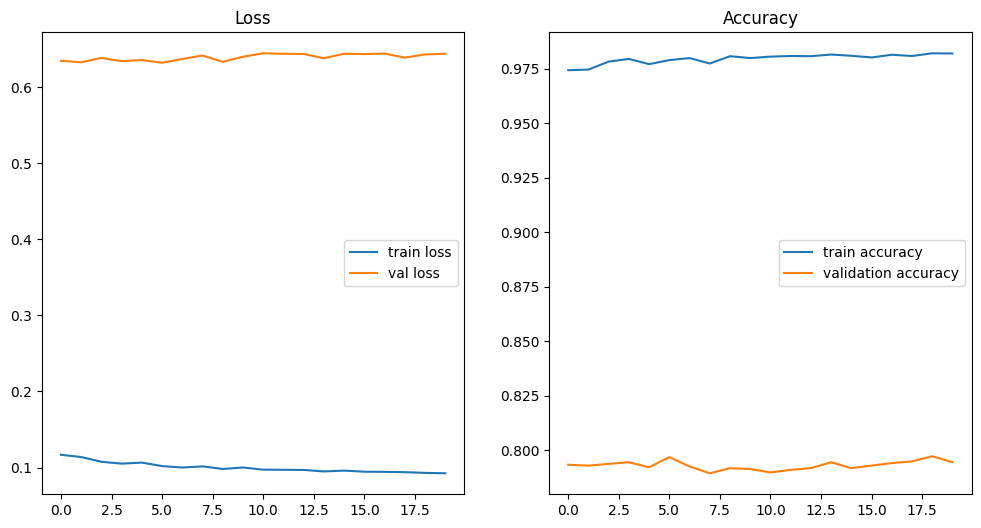

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## changing the optimizer to RMSprop
# but the result is worst than previous optimiser - SGD

# **opt = RSMprop**

In [ ]:
# Compile the model
from keras.optimizers import RMSprop

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
82/82 [==============================] - 28s 234ms/step - loss: 0.4428 - accuracy: 0.8698 - val_loss: 0.6458 - val_accuracy: 0.7871
Epoch 2/20
82/82 [==============================] - 16s 189ms/step - loss: 0.3137 - accuracy: 0.8977 - val_loss: 0.7374 - val_accuracy: 0.7605
Epoch 3/20
82/82 [==============================] - 17s 212ms/step - loss: 0.2660 - accuracy: 0.9038 - val_loss: 0.7120 - val_accuracy: 0.7781
Epoch 4/20
82/82 [==============================] - 18s 219ms/step - loss: 0.2439 - accuracy: 0.9130 - val_loss: 0.6810 - val_accuracy: 0.7836
Epoch 5/20
82/82 [==============================] - 18s 214ms/step - loss: 0.2252 - accuracy: 0.9168 - val_loss: 0.7786 - val_accuracy: 0.7629
Epoch 6/20
82/82 [==============================] - 18s 214ms/step - loss: 0.2074 - accuracy: 0.9257 - val_loss: 0.7142 - val_accuracy: 0.7805
Epoch 7/20
82/82 [==============================] - 15s 187ms/step - loss: 0.1923 - accuracy: 0.9327 - val_loss: 0.8740 - val_accuracy: 0.7324

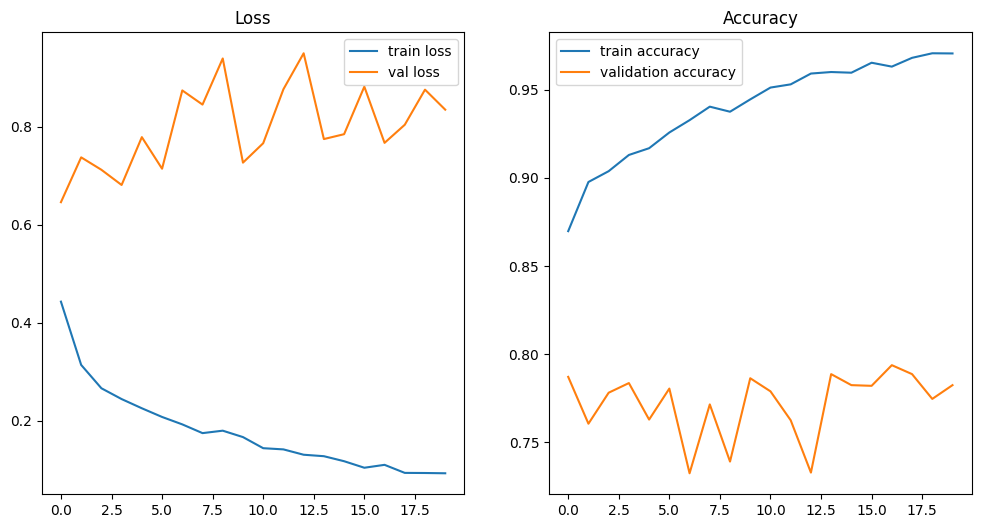

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## now i am going to use SGD optimiser with its own parameters with changing the learning rate to 0.00005

# **opt=SGD - Lr=0.00005**

In [ ]:
from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
82/82 [==============================] - 31s 259ms/step - loss: 0.0459 - accuracy: 0.9885 - val_loss: 0.7851 - val_accuracy: 0.7965
Epoch 2/20
82/82 [==============================] - 18s 216ms/step - loss: 0.0344 - accuracy: 0.9926 - val_loss: 0.7857 - val_accuracy: 0.7945
Epoch 3/20
82/82 [==============================] - 16s 189ms/step - loss: 0.0323 - accuracy: 0.9931 - val_loss: 0.7858 - val_accuracy: 0.7934
Epoch 4/20
82/82 [==============================] - 15s 186ms/step - loss: 0.0315 - accuracy: 0.9934 - val_loss: 0.7820 - val_accuracy: 0.7949
Epoch 5/20
82/82 [==============================] - 16s 191ms/step - loss: 0.0289 - accuracy: 0.9941 - val_loss: 0.7843 - val_accuracy: 0.7941
Epoch 6/20
82/82 [==============================] - 18s 219ms/step - loss: 0.0286 - accuracy: 0.9953 - val_loss: 0.7897 - val_accuracy: 0.7937
Epoch 7/20
82/82 [==============================] - 16s 191ms/step - loss: 0.0271 - accuracy: 0.9945 - val_loss: 0.7956 - val_accuracy: 0.7926

In [ ]:
## but the result in not improved and it is not good

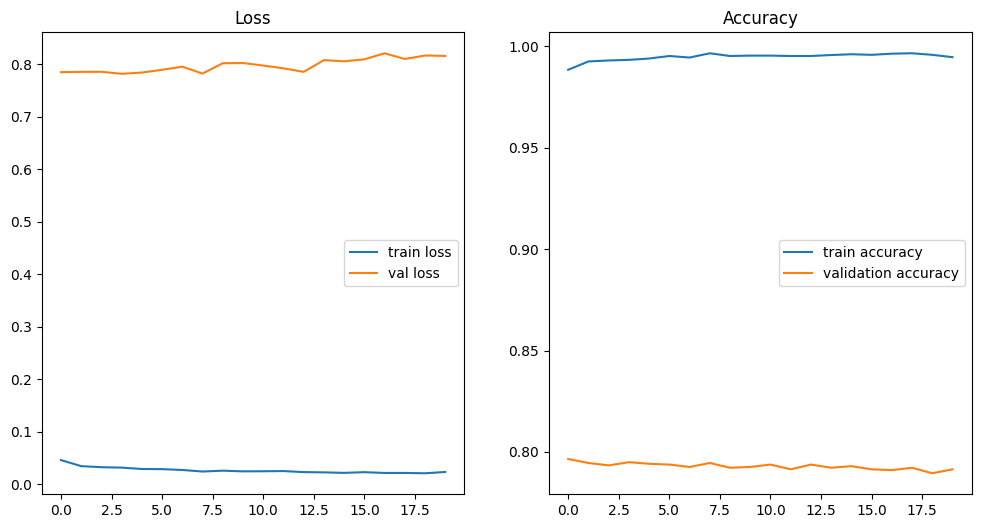

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## now i am going to try the data augmentation
## using 64 batch and 20 epochs
## SGD optimiser with the 0.0001 lr

# **Data augmentation - batch=128 - epoch=20 - opt=SGD with 0.0001**

In [ ]:
# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:
from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Epoch 1/20
82/82 [==============================] - 68s 720ms/step - loss: 1.0420 - accuracy: 0.6834 - val_loss: 0.6432 - val_accuracy: 0.7719
Epoch 2/20
82/82 [==============================] - 56s 683ms/step - loss: 0.8253 - accuracy: 0.6927 - val_loss: 0.6258 - val_accuracy: 0.7766
Epoch 3/20
82/82 [==============================] - 58s 703ms/step - loss: 0.7999 - accuracy: 0.6942 - val_loss: 0.6259 - val_accuracy: 0.7773
Epoch 4/20
82/82 [==============================] - 55s 676ms/step - loss: 0.7926 - accuracy: 0.6976 - val_loss: 0.6115 - val_accuracy: 0.7820
Epoch 5/20
82/82 [==============================] - 57s 686ms/step - loss: 0.7703 - accuracy: 0.7030 - val_loss: 0.6185 - val_accuracy: 0.7824
Epoch 6/20
82/82 [==============================] - 57s 692ms/step - loss: 0.7708 - accuracy: 0.7039 - val_loss: 0.6098 - val_accuracy: 0.7867
Epoch 7/20
82/82 [==============================] - 56s 687ms/step - loss: 0.7550 - accuracy: 0.7057 - val_loss: 0.6173 - val_accuracy: 0.7805

In [ ]:
# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

2/2 [==============================] - 1s 534ms/step - loss: 1.2536 - accuracy: 0.5851
Test Accuracy: 0.5850622653961182
Test Loss: 1.2536187171936035


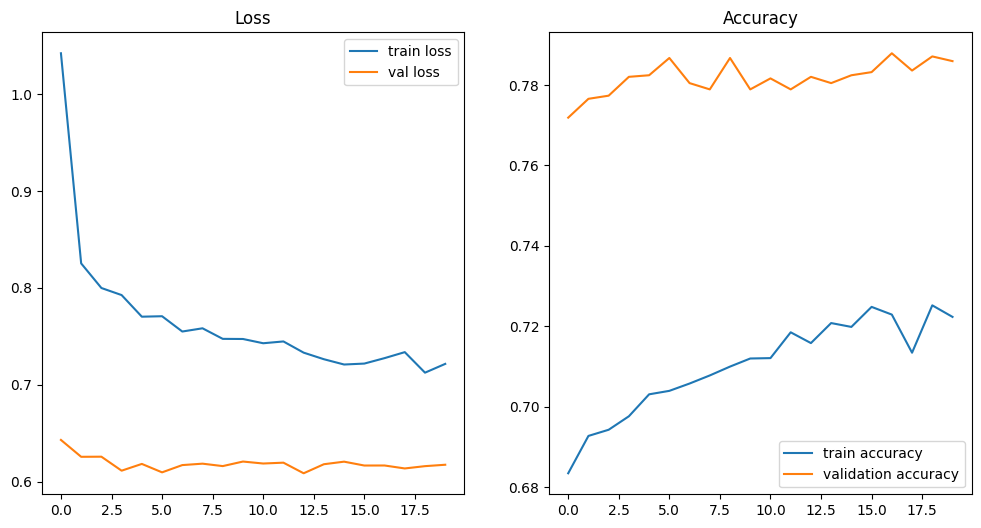

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## darvaghe data augmentation ,  test accuracy ro balatar bord.

In [ ]:
## hala agar batch size ro 64 bezarim
# epoch ro ham konim 50, che etefaghi miofte? ba hamoon data augmentation

# **batch=64 - epoch=50**

In [ ]:
batch_size = 64

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.


In [ ]:
from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/50
165/165 [==============================] - 72s 377ms/step - loss: 0.7306 - accuracy: 0.7197 - val_loss: 0.6130 - val_accuracy: 0.7866
Epoch 2/50
165/165 [==============================] - 61s 368ms/step - loss: 0.7256 - accuracy: 0.7173 - val_loss: 0.6178 - val_accuracy: 0.7774
Epoch 3/50
165/165 [==============================] - 59s 354ms/step - loss: 0.7071 - accuracy: 0.7324 - val_loss: 0.6106 - val_accuracy: 0.7851
Epoch 4/50
165/165 [==============================] - 60s 363ms/step - loss: 0.7147 - accuracy: 0.7206 - val_loss: 0.6110 - val_accuracy: 0.7843
Epoch 5/50
165/165 [==============================] - 60s 361ms/step - loss: 0.6999 - accuracy: 0.7291 - val_loss: 0.6081 - val_accuracy: 0.7828
Epoch 6/50
165/165 [==============================] - 59s 361ms/step - loss: 0.6984 - accuracy: 0.7290 - val_loss: 0.6129 - val_accuracy: 0.7824
Epoch 7/50
165/165 [==============================] - 58s 352ms/step - loss: 0.7006 - accuracy: 0.7287 - val_loss: 0.6150 - val_ac

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## ba in hesab darvaghe ta alan az hame behtar: hamoon data augmentation
## using 128 batch and 20 epochs
## SGD optimiser with the 0.0001 lr

## vali train accuracy e without data augmentation behtar bood.

## hala ba tavajoh be bala ru epoch e 25 ham khub javab dadae ke alan dobare emtehan mikonim
# vali alan ba lr = .00005 daram test mikonam

In [ ]:
## vali inja az batch e 64 estefade kardam eshtebahi

# **epoch=25 - batch=64 - Lr=0.0001**

In [ ]:
from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/25
165/165 [==============================] - 71s 372ms/step - loss: 0.6410 - accuracy: 0.7570 - val_loss: 0.5962 - val_accuracy: 0.7915
Epoch 2/25
165/165 [==============================] - 59s 358ms/step - loss: 0.6298 - accuracy: 0.7561 - val_loss: 0.6061 - val_accuracy: 0.7896
Epoch 3/25
165/165 [==============================] - 58s 353ms/step - loss: 0.6341 - accuracy: 0.7588 - val_loss: 0.6077 - val_accuracy: 0.7881
Epoch 4/25
165/165 [==============================] - 59s 359ms/step - loss: 0.6233 - accuracy: 0.7594 - val_loss: 0.5998 - val_accuracy: 0.7931
Epoch 5/25
165/165 [==============================] - 59s 360ms/step - loss: 0.6295 - accuracy: 0.7564 - val_loss: 0.6021 - val_accuracy: 0.7923
Epoch 6/25
165/165 [==============================] - 59s 360ms/step - loss: 0.6340 - accuracy: 0.7612 - val_loss: 0.5997 - val_accuracy: 0.7881
Epoch 7/25
165/165 [==============================] - 59s 355ms/step - loss: 0.6247 - accuracy: 0.7608 - val_loss: 0.5997 - val_ac

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## now i want to check the previous one with 128 batchs and 7 epochs (choon ye bar ejra kardam didam 7 behtare)

# **batch=128 - epoch=7**

In [ ]:
# Define image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 128

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


# compile

from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=7,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.
Epoch 1/7
82/82 [==============================] - 69s 734ms/step - loss: 0.6196 - accuracy: 0.7655 - val_loss: 0.5978 - val_accuracy: 0.7926
Epoch 2/7
82/82 [==============================] - 59s 715ms/step - loss: 0.6173 - accuracy: 0.7649 - val_loss: 0.6020 - val_accuracy: 0.7926
Epoch 3/7
82/82 [==============================] - 60s 730ms/step - loss: 0.6161 - accuracy: 0.7640 - val_loss: 0.6055 - val_accuracy: 0.7934
Epoch 4/7
82/82 [==============================] - 56s 683ms/step - loss: 0.5995 - accuracy: 0.7684 - val_loss: 0.5997 - val_accuracy: 0.7922
Epoch 5/7
82/82 [==============================] - 56s 678ms/step - loss: 0.6171 - accuracy: 0.7649 - val_loss: 0.6067 - val_accuracy: 0.7930
Epoch 6/7
82/82 [==============================] - 57s 690ms/step - loss: 0.6133 - accuracy: 0.7679 - val_loss: 0.6017 - val_accuracy: 0.7906
Epoch 7/7
21/21 [==============================] - 3s 150ms/ste

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## this was the best model

In [ ]:
# beside the last adjustments i want to add 2 more layers
## adding two more layer : Dense layers (512 units and 256 units) after the initial Dense layer with 1024 units.
# but the accuracy decreased

# **adjusting layers**

In [ ]:
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add another fully-connected layer
x = Dense(512, activation='relu')(x)

# Add another fully-connected layer
x = Dense(256, activation='relu')(x)

# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False


# compile

from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=7,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])


Epoch 1/7
82/82 [==============================] - 85s 855ms/step - loss: 1.3732 - accuracy: 0.3666 - val_loss: 1.2841 - val_accuracy: 0.4563
Epoch 2/7
82/82 [==============================] - 57s 692ms/step - loss: 1.2603 - accuracy: 0.4567 - val_loss: 1.2346 - val_accuracy: 0.4617
Epoch 3/7
82/82 [==============================] - 58s 710ms/step - loss: 1.2253 - accuracy: 0.4682 - val_loss: 1.1919 - val_accuracy: 0.4789
Epoch 4/7
82/82 [==============================] - 60s 728ms/step - loss: 1.1911 - accuracy: 0.4897 - val_loss: 1.1640 - val_accuracy: 0.4953
Epoch 5/7
82/82 [==============================] - 56s 685ms/step - loss: 1.1644 - accuracy: 0.5084 - val_loss: 1.1389 - val_accuracy: 0.5086
Epoch 6/7
82/82 [==============================] - 58s 702ms/step - loss: 1.1393 - accuracy: 0.5169 - val_loss: 1.1117 - val_accuracy: 0.5320
Epoch 7/7
21/21 [==============================] - 3s 143ms/step - loss: 1.0908 - accuracy: 0.5486
Validation Loss: 1.0907642841339111
Validation Ac

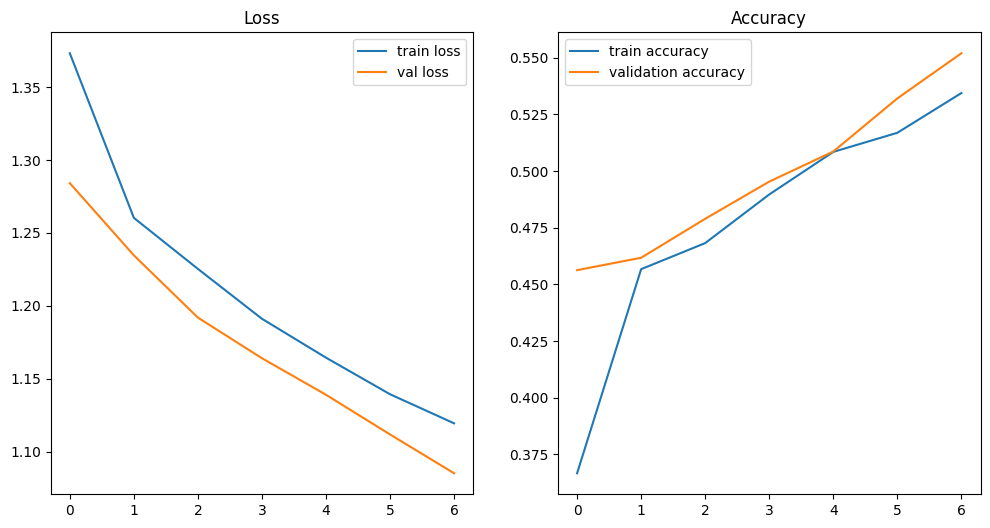

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## let's increase the number of epochs to 20

# **epoch=20**

In [ ]:
# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])


Epoch 1/20
82/82 [==============================] - 57s 700ms/step - loss: 1.1031 - accuracy: 0.5424 - val_loss: 1.0712 - val_accuracy: 0.5637
Epoch 2/20
82/82 [==============================] - 60s 733ms/step - loss: 1.0879 - accuracy: 0.5529 - val_loss: 1.0562 - val_accuracy: 0.5684
Epoch 3/20
82/82 [==============================] - 57s 698ms/step - loss: 1.0681 - accuracy: 0.5625 - val_loss: 1.0406 - val_accuracy: 0.5793
Epoch 4/20
82/82 [==============================] - 59s 720ms/step - loss: 1.0558 - accuracy: 0.5723 - val_loss: 1.0286 - val_accuracy: 0.5859
Epoch 5/20
82/82 [==============================] - 56s 686ms/step - loss: 1.0470 - accuracy: 0.5760 - val_loss: 1.0086 - val_accuracy: 0.5965
Epoch 6/20
82/82 [==============================] - 56s 685ms/step - loss: 1.0333 - accuracy: 0.5760 - val_loss: 0.9972 - val_accuracy: 0.6055
Epoch 7/20
82/82 [==============================] - 57s 693ms/step - loss: 1.0251 - accuracy: 0.5810 - val_loss: 0.9904 - val_accuracy: 0.6062

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## now i just want to change one of the previous layers:

# **again adjusting layers**

In [ ]:
# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add another fully-connected layer
x = Dense(512, activation='relu')(x)

# Add another fully-connected layer with 256 units and 'sigmoid' activation
x = Dense(256, activation='sigmoid')(x)


# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

####### in ghesmate freezing ro bayad ghabl az adding layer anjam dad ya badesh?
### hala pas baad az in ye code ejra konam ke baraxe in bashe


# compile

from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])


Epoch 1/20
82/82 [==============================] - 68s 724ms/step - loss: 1.3151 - accuracy: 0.4333 - val_loss: 1.2848 - val_accuracy: 0.4555
Epoch 2/20
82/82 [==============================] - 67s 824ms/step - loss: 1.2793 - accuracy: 0.4553 - val_loss: 1.2718 - val_accuracy: 0.4547
Epoch 3/20
82/82 [==============================] - 65s 797ms/step - loss: 1.2680 - accuracy: 0.4563 - val_loss: 1.2614 - val_accuracy: 0.4566
Epoch 4/20
82/82 [==============================] - 70s 852ms/step - loss: 1.2595 - accuracy: 0.4570 - val_loss: 1.2532 - val_accuracy: 0.4570
Epoch 5/20
82/82 [==============================] - 60s 730ms/step - loss: 1.2537 - accuracy: 0.4569 - val_loss: 1.2457 - val_accuracy: 0.4566
Epoch 6/20
82/82 [==============================] - 59s 723ms/step - loss: 1.2484 - accuracy: 0.4560 - val_loss: 1.2366 - val_accuracy: 0.4574
Epoch 7/20
82/82 [==============================] - 57s 691ms/step - loss: 1.2404 - accuracy: 0.4580 - val_loss: 1.2321 - val_accuracy: 0.4555

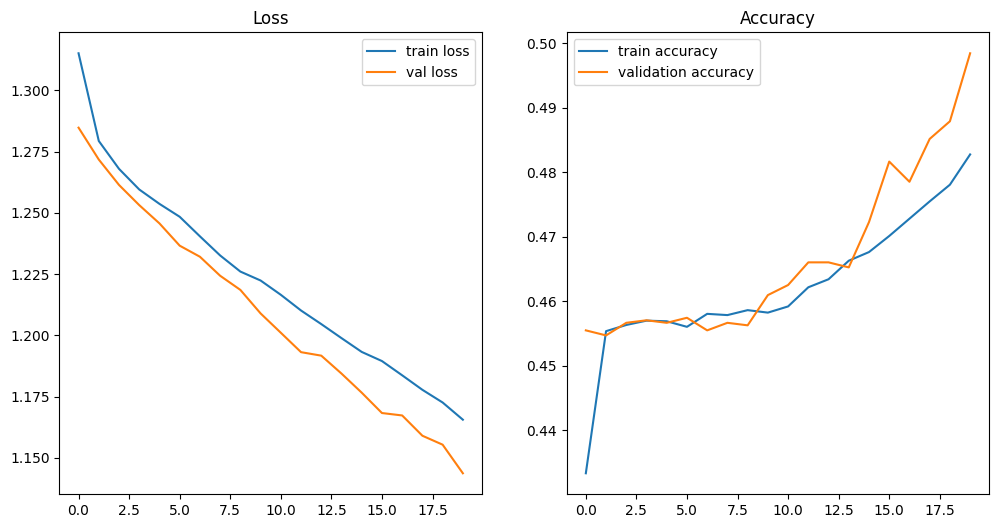

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## chun shak dashtam ke ghesmate freezing layer bayad dar kodum ghesmat gharar begire, umadam ye bare dge code ghabltari ke activation=relu bud ro ejra kardam vali
## vali in dafe freezing ro aval, yani ghabl az layer ha
## tedad e epoch ro ham kardam 10 ta
## albate activation e sigmoid ro be hamoon relu taghir dadam (yani mesle code ghable balaei )

In [ ]:
# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add another fully-connected layer
x = Dense(512, activation='relu')(x)

# Add another fully-connected layer with 256 units and 'sigmoid' activation
x = Dense(256, activation='relu')(x)


# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)


# compile

from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])


Epoch 1/10
82/82 [==============================] - 71s 738ms/step - loss: 1.2992 - accuracy: 0.4367 - val_loss: 1.2405 - val_accuracy: 0.4719
Epoch 2/10
82/82 [==============================] - 58s 711ms/step - loss: 1.2348 - accuracy: 0.4769 - val_loss: 1.1937 - val_accuracy: 0.4957
Epoch 3/10
82/82 [==============================] - 57s 698ms/step - loss: 1.1891 - accuracy: 0.5030 - val_loss: 1.1510 - val_accuracy: 0.5180
Epoch 4/10
82/82 [==============================] - 58s 710ms/step - loss: 1.1518 - accuracy: 0.5231 - val_loss: 1.1167 - val_accuracy: 0.5340
Epoch 5/10
82/82 [==============================] - 57s 688ms/step - loss: 1.1264 - accuracy: 0.5337 - val_loss: 1.0890 - val_accuracy: 0.5598
Epoch 6/10
82/82 [==============================] - 57s 686ms/step - loss: 1.1027 - accuracy: 0.5441 - val_loss: 1.0691 - val_accuracy: 0.5668
Epoch 7/10
82/82 [==============================] - 59s 722ms/step - loss: 1.0806 - accuracy: 0.5567 - val_loss: 1.0520 - val_accuracy: 0.5703

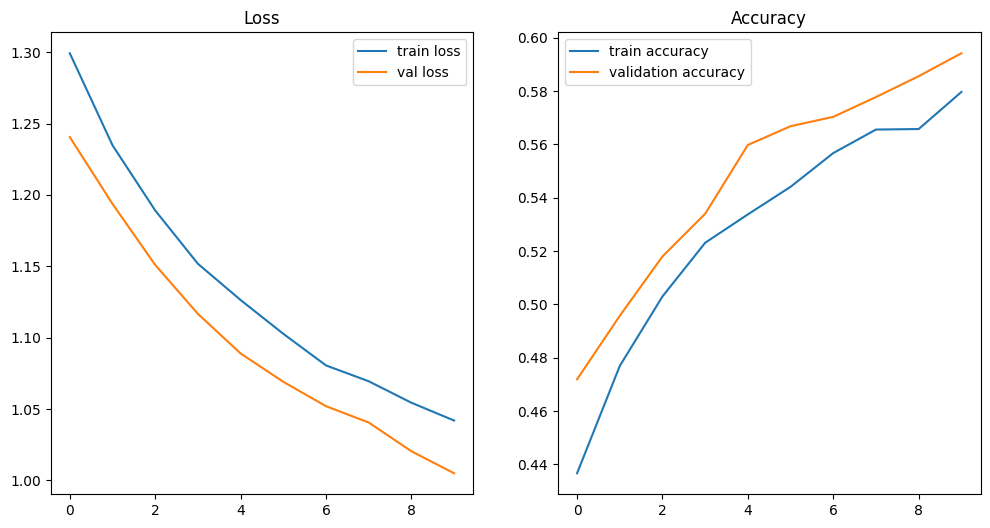

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
### prediction ###

1/1 [==============================] - 5s 5s/step


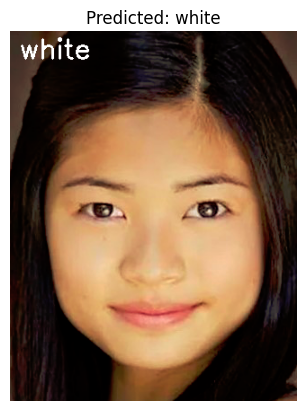

1/1 [==============================] - 0s 43ms/step


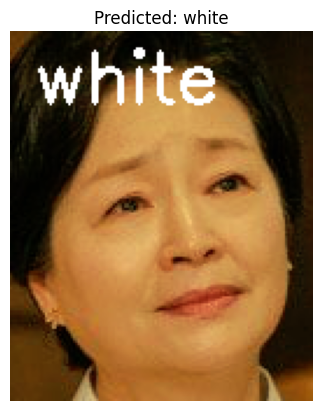

1/1 [==============================] - 0s 43ms/step


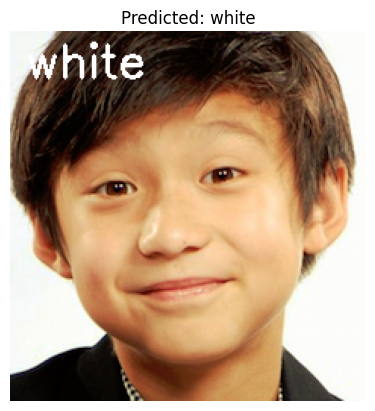

1/1 [==============================] - 0s 42ms/step


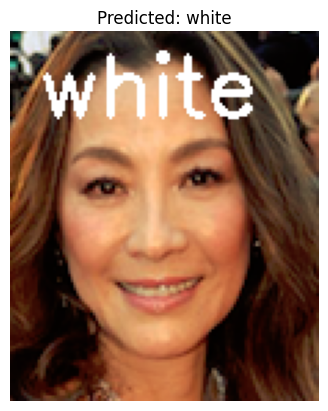

1/1 [==============================] - 0s 37ms/step


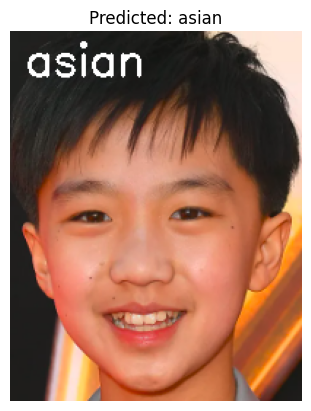

1/1 [==============================] - 0s 34ms/step


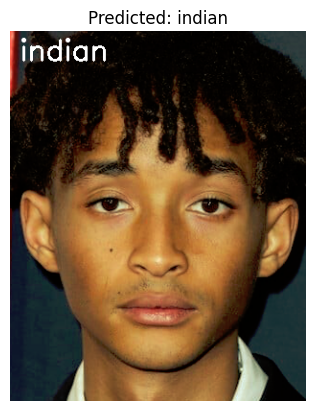

1/1 [==============================] - 0s 34ms/step


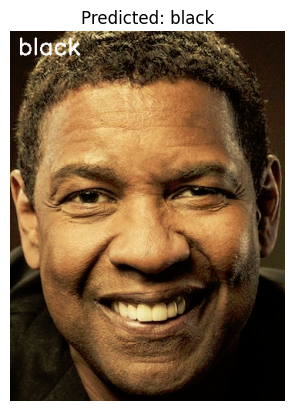

1/1 [==============================] - 0s 43ms/step


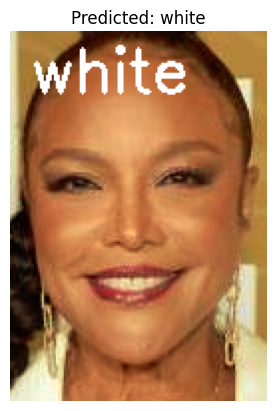

1/1 [==============================] - 0s 33ms/step


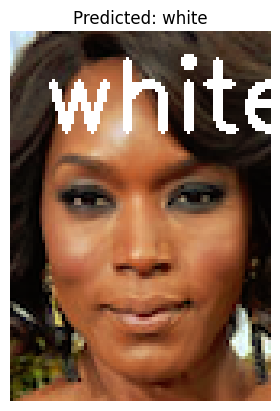

1/1 [==============================] - 0s 34ms/step


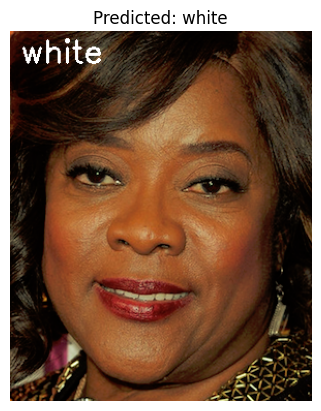

1/1 [==============================] - 0s 63ms/step


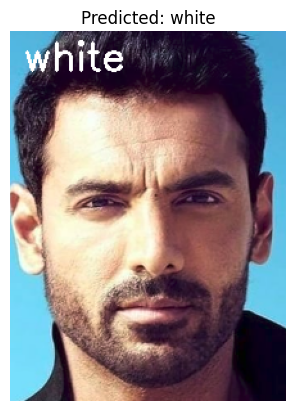

1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 54ms/step


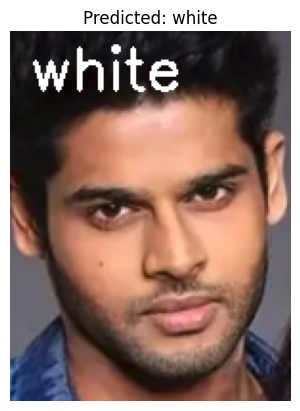

1/1 [==============================] - 0s 61ms/step


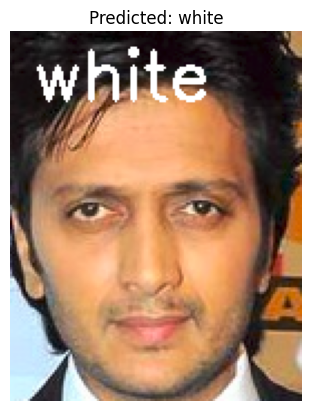

1/1 [==============================] - 0s 63ms/step


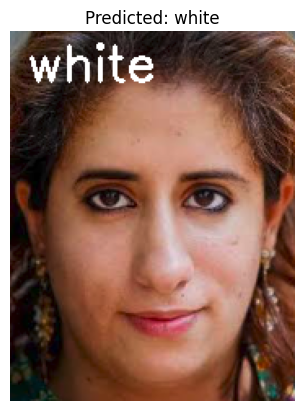

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 63ms/step


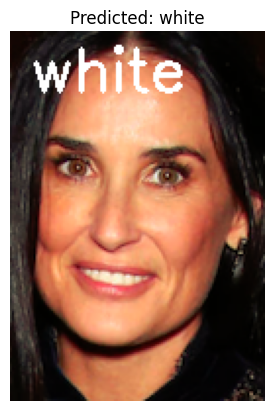

1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 32ms/step


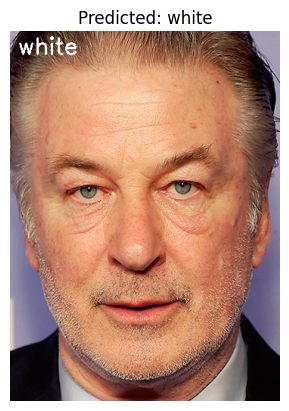

1/1 [==============================] - 0s 42ms/step


In [ ]:
#image_path = "/content/test_dataset/specific_dataset"

def predict_on_image(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise Exception(f"Failed to load the image at {image_path}. Check file format.")
    img = cv2.resize(img, (128, 128))  # Resize to the expected input size of the model
    img = img.astype('float32') / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    return categories[predicted_class_index]  # Return the predicted category


import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

new_sample_dir = "/content/test_dataset/specific_dataset"
categories = ['asian', 'black', 'indian', 'white']

for category in categories:
    category_path = os.path.join(new_sample_dir, category)
    if os.path.isdir(category_path):
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        selected_files = random.sample(image_files, min(5, len(image_files)))
        for image_file in selected_files:
            image_path = os.path.join(category_path, image_file)
            try:
                predicted_age_class = predict_on_image(image_path, model)
                img_bgr = cv2.imread(image_path)
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                cv2.putText(img_rgb, predicted_age_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                plt.imshow(img_rgb)
                plt.title(f"Predicted: {predicted_age_class}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")

In [ ]:
##################################################################################################################################

In [ ]:
## running the best model again
## but this time the accuracy is completely changed

In [ ]:
# Define image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 128

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes for ethnicities

# Compile the model
# compile

from keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=7,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 10564 images belonging to 4 classes.
Found 2643 images belonging to 4 classes.
Epoch 1/7
82/82 [==============================] - 70s 744ms/step - loss: 1.5875 - accuracy: 0.4290 - val_loss: 1.0378 - val_accuracy: 0.5895
Epoch 2/7
82/82 [==============================] - 60s 713ms/step - loss: 1.2180 - accuracy: 0.5150 - val_loss: 0.9532 - val_accuracy: 0.6152
Epoch 3/7
82/82 [==============================] - 57s 696ms/step - loss: 1.1250 - accuracy: 0.5452 - val_loss: 0.9338 - val_accuracy: 0.6316
Epoch 4/7
82/82 [==============================] - 56s 684ms/step - loss: 1.0728 - accuracy: 0.5704 - val_loss: 0.8966 - val_accuracy: 0.6473
Epoch 5/7
82/82 [==============================] - 59s 725ms/step - loss: 1.0257 - accuracy: 0.5832 - val_loss: 0.8877 - val_accuracy: 0.6504
Epoch 6/7
82/82 [==============================] - 59s 725ms/step - loss: 1.0074 - accuracy: 0.5960 - val_loss: 0.8679 - val_accuracy: 0.6594
Epoch 7/7
21/21 [==============================] - 3s 148ms/ste

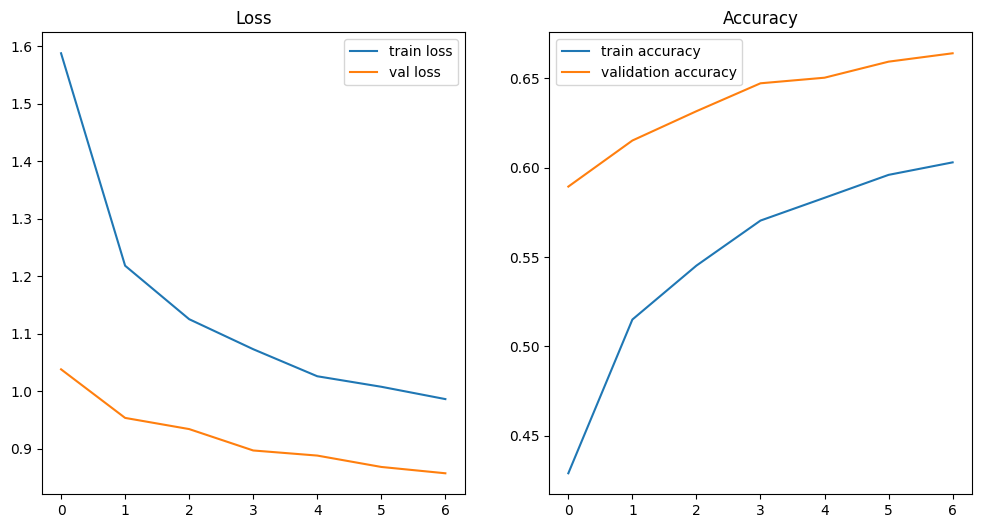

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='train loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='train accuracy')
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


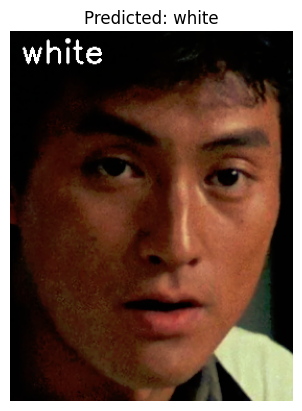

1/1 [==============================] - 0s 38ms/step


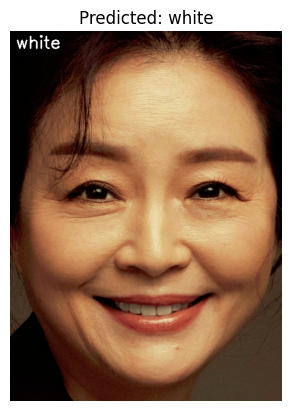

1/1 [==============================] - 0s 34ms/step


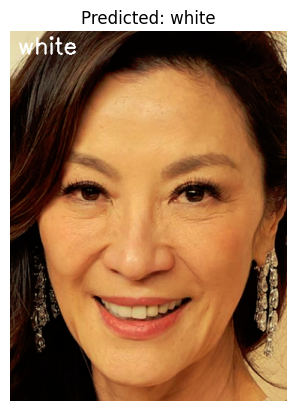

1/1 [==============================] - 0s 34ms/step


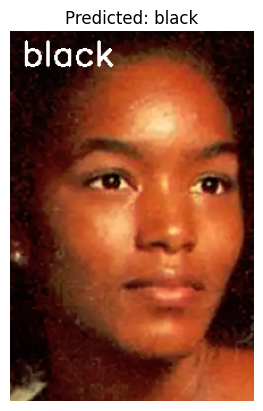

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 55ms/step


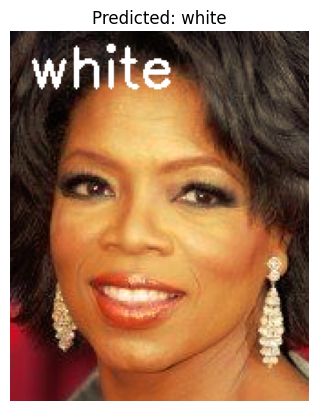

1/1 [==============================] - 0s 40ms/step


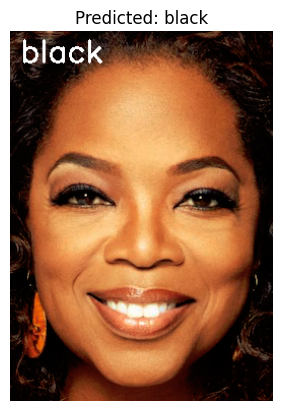

1/1 [==============================] - 0s 35ms/step


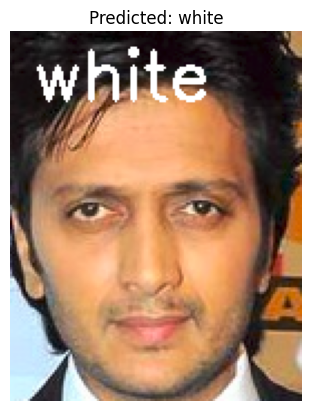

1/1 [==============================] - 0s 37ms/step


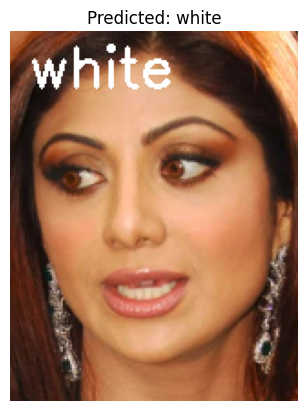

1/1 [==============================] - 0s 41ms/step


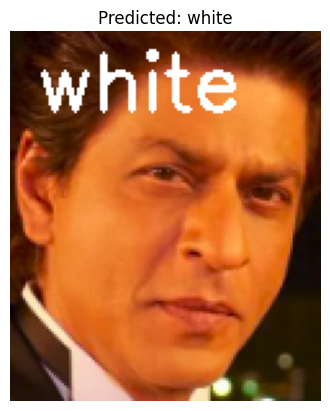

1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 94ms/step


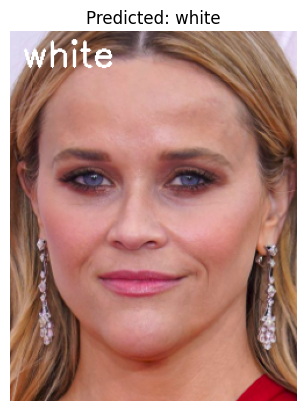

1/1 [==============================] - 0s 80ms/step


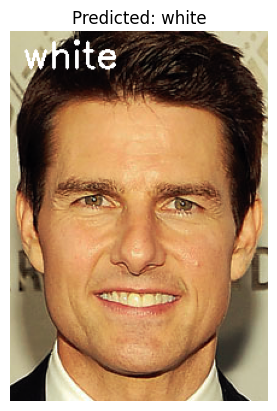

1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 59ms/step


In [ ]:
def predict_on_image(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise Exception(f"Failed to load the image at {image_path}. Check file format.")
    img = cv2.resize(img, (128, 128))  # Resize to the expected input size of the model
    img = img.astype('float32') / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    return categories[predicted_class_index]  # Return the predicted category


import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

new_sample_dir = "/content/test_dataset/specific_dataset"
categories = ['asian', 'black', 'indian', 'white']

for category in categories:
    category_path = os.path.join(new_sample_dir, category)
    if os.path.isdir(category_path):
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        selected_files = random.sample(image_files, min(5, len(image_files)))
        for image_file in selected_files:
            image_path = os.path.join(category_path, image_file)
            try:
                predicted_age_class = predict_on_image(image_path, model)
                img_bgr = cv2.imread(image_path)
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                cv2.putText(img_rgb, predicted_age_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                plt.imshow(img_rgb)
                plt.title(f"Predicted: {predicted_age_class}")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")